# Age Estimation 

In [88]:
import numpy as np
import os
from math import * 
from helperP import *

# Loading Data

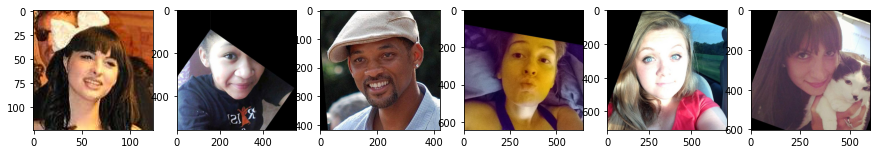

In [89]:
base_dir = 'DATASET/'

age_train, features_train = prepare_data('train', base_dir)
age_val, features_val = prepare_data('val', base_dir)
_, features_test = prepare_data('test', base_dir)
show_data(base_dir)


## Linear class
	LINEAR
	Implementation of the linear layer (also called fully connected layer)
	which performs linear transoformation on input data y = xW + b.
	This layer has two learnable parameters, weight of shape (input_channel, output_channel)
	and bias of shape (output_channel), which are specified and initalized in init_param()
	function. In this assignment, you need to implement both forward and backward computation
	Arguments:
		input_channel  -- integer, number of input channels
		output_channel -- integer, number of output channels

In [90]:
class Linear(object):

    def __init__(self, input_channel, output_channel):
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.init_param()

    def init_param(self):
        ##################################################
        # TODO: YOUR CODE HERE: init weights
        ##################################################
        self.w = np.random.normal(0, 1, size=(self.input_channel, self.output_channel))
        self.b = np.zeros((self.output_channel,1))
        self.lr = 0.1

    '''
        Forward computation of linear layer, you may want to save some intermediate
        variable to class membership (self.) for reusing in backward computation.
        Arguments:
            input -- numpy array of shape (N, input_channel)

        Output:
            output -- numpy array of shape (N, output_channel)
    '''
    def forward(self, input):
        self.input = input
        ##################################################
        # TODO: YOUR CODE HERE: forward
        ##################################################
        output = np.dot(self.input, self.w)
        for o in output:
            o = o.reshape(self.b.shape)
            o += self.b
        return output

    '''
        Backward computation of linear layer, you need to compute the gradient
        w.r.t input, weight and bias respectively. You need to reuse the variable in forward
        computation to compute backward gradient.

        Arguments:
            grad_output -- numpy array of shape (N, output_channel)

        Output:
            grad_input -- numpy array of shape (N, input_channel), gradient w.r.t input
            grad_weight -- numpy array of shape (input_channel, output_channel), gradient w.r.t weight
            grad_bias --  numpy array of shape (output_channel), gradient w.r.t bias
    '''
    def backward(self, grad_output):
        ##################################################
        # TODO: YOUR CODE HERE: backward
        ##################################################
        grad_bias = grad_output[0] #TBD: How will this be calculated?
        grad_weight = np.dot(self.input.T, grad_output)
        grad_input = np.dot(grad_output, self.w.T)
        return grad_input, grad_weight, grad_bias


In [91]:
## Test ##
model = Linear(10, 2)
x = np.random.randn(5, 10)
y = model.forward(x)
assert y.shape[0] == 5
assert y.shape[1] == 2
grad = np.ones((5, 2))
grad_in, grad_w, grad_b = model.backward(grad)
assert grad_in.shape == (5, 10)
assert grad_w.shape == (10, 2)
assert grad_b.shape[0] == 2
print('test passed')

test passed


## CROSS_ENTROPY_LOSS_WITH_SOFTMAX
	Implementation of the combination of softmax function and cross entropy loss.
	In classification task, we usually firstly apply softmax to map class-wise prediciton
	into the probabiltiy distribution then we use cross entropy loss to maximise the likelihood
	of ground truth class's prediction. Since softmax includes exponential term and cross entropy includes
	log term, we can simplify the formula by combining these two functions togther so that log and exp term could cancell out
	mathmatically and we can avoid precision lost with float point numerical computation.
	If we ignore the index on batch sizel and assume there is only one grouth truth per sample,
	the formula for softmax and cross entropy loss are:
		Softmax: prob[i] = exp(x[i]) / \sum_{j}exp(x[j])
		Cross_entropy_loss:  - 1 * log(prob[gt_class])
	Combining these two function togther, we got
		cross_entropy_with_softmax: -x[gt_class] + log(\sum_{j}exp(x[j]))
	In this assignment, you will implement both forward and backward computation.
	Arguments:
		None

In [92]:
class CrossEntropyLossWithSoftmax(object):
    def __init__(self):
        pass
    
    '''
        Forward computation of cross entropy with softmax, you may want to save some intermediate variables to class membership (self.)
        Arguments:
            input    -- numpy array of shape (N, C), the prediction for each class, where C is number of class
            gt_label -- numpy array of shape (N), it's a integer array and the value range from 0 to C-1 which
                        specify the ground truth class for each input
        Output:
            output   -- numpy array of shape (N), containing the cross entropy loss on each input
    '''
    def forward(self, input, gt_label):
        self.gt_label = gt_label
        self.input = input
        
        ##################################################
        # TODO: YOUR CODE HERE: forward
        ##################################################
        output = []
        for i in range(len(gt_label)):
            z = input[i]
            gt_index = gt_label[i]
            output.append(-z[gt_index] + np.log(np.exp(z).sum()))
        return np.array(output)

    '''
        Backward computation of cross entropy with softmax. It's recommended to resue the variable
        in forward computation to simplify the formula.
        Arguments:
            grad_output -- numpy array of shape (N)

        Output:
            grad_input  -- numpy array of shape (N, C), the gradient w.r.t input of forward function
    '''
    def backward(self, grad_output):
        ##################################################
        # TODO: YOUR CODE HERE: backward
        ##################################################
        grad_output = grad_output.astype(np.int16)
        grad_input = []
        for i in range(len(self.gt_label)):
            z = self.input[i]
            gt_label = np.zeros(self.input.shape[1])
            gt_label[self.gt_label[i]] = 1
            gradient_z = -gt_label + self.softmax(z) 
            grad_input.append(gradient_z)
        return grad_input
    
    def softmax(self, x):
        return np.exp(x) / np.exp(x).sum()


In [93]:
## Test ##
np.random.seed(0)
model = CrossEntropyLossWithSoftmax()
input = np.random.randn(10, 3)
gt_label = np.random.randint(0, 3, size=(10))
out = model.forward(input, gt_label)
out_res = np.array([0.53745158, 0.92056757, 1.57279876, 0.48360825, 0.81351897,
       0.40291668, 1.48063859, 0.69837844, 3.84838034, 0.81371399])
assert np.allclose(out, out_res)
grad = np.ones(10)
out_grad = model.backward(grad)
grad_res = np.array([[-0.41576477,  0.14936733,  0.26639744],
       [ 0.57854881, -0.60170708,  0.02315827],
       [ 0.59482294,  0.19771333, -0.79253627],
       [ 0.21712474,  0.16632057, -0.38344531],
       [-0.55670463,  0.2338953 ,  0.32280932],
       [ 0.20943928, -0.33163222,  0.12219294],
       [ 0.73090254, -0.77250763,  0.04160509],
       [ 0.40284797, -0.5026088 ,  0.09976083],
       [ 0.88315015, -0.97868577,  0.09553562],
       [ 0.08456316,  0.47222791, -0.55679107]])
assert np.allclose(out_grad, grad_res)
print('test passed')

test passed


# Implement Stochastic Gradient descent
Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning.
```
Arguments:
    age          -- numpy array, label, (n, )
    feature      -- numpy array, features, (n, 2048)
Return:
    weights      -- numpy array, (2048, )
    bias         -- numpy array, (1, )
```

In [94]:
def stochastic_gradient_descent(age, feature, age_val, feature_val):
    # check the inputs
    assert len(age) == len(feature)

    # Set the random seed
    np.random.seed(0)

    # Define the layers
    fc = Linear(2048, 101)
    cretirion = CrossEntropyLossWithSoftmax()

    # Initialize parameters of the layers
    fc.init_param()

    # Number of mini-batches
    t = len(age) // batch_size

    # Optimal weights and loss for val
    weights_opt = []
    bias_opt = []
    loss_opt = 1e6

    for e in range(epoch_sgd):
        # Shuffle training data
        n = np.random.permutation(len(feature))

        for m in range(t):
            # Providing mini batch with fixed batch size of 16
            batch_feature = feature[n[m * batch_size: (m + 1) * batch_size]]
            batch_age = age[n[m * batch_size: (m + 1) * batch_size]].reshape(-1, 1).astype(np.int16).squeeze()

            # forward pass
            z = fc.forward(batch_feature)
            ce = cretirion.forward(z, batch_age)
            loss = ce.sum()

            # calculate gradient here
            dz = cretirion.backward(np.ones_like(ce))
            dinput, dweight, dbias = fc.backward(dz)
            dbias = dbias.reshape(dbias.shape[0],1)

            # update the gradient here
#             print(fc.b.shape)
#             print((dbias*lr).shape)
#             print(lr.shape)
            fc.w -= dweight * lr
            fc.b -= dbias * lr

        ##################################################
        # TODO: YOUR CODE HERE
        ##################################################
        # calcualte the loss on validation set
        pred_val = fc.forward(feature)
        loss_val = cretirion.forward(pred_val, age.astype(np.int16)).sum()


        if (loss_opt > loss_val):
            print('updated:')
            loss_opt = loss_val
            weights_opt = fc.w
            bias_opt = fc.b

        print('=> epoch:', e + 1, ' Validation Loss:', round(loss_val, 4))
    return weights_opt, bias_opt

# Train and validate

updated:
=> epoch: 1  Validation Loss: 44706.4905
updated:
=> epoch: 2  Validation Loss: 29447.4234
updated:
=> epoch: 3  Validation Loss: 22597.6083
updated:
=> epoch: 4  Validation Loss: 19226.5719
updated:
=> epoch: 5  Validation Loss: 17222.1762
updated:
=> epoch: 6  Validation Loss: 16091.9748
updated:
=> epoch: 7  Validation Loss: 15184.4288
updated:
=> epoch: 8  Validation Loss: 14522.635
updated:
=> epoch: 9  Validation Loss: 14020.4755
updated:
=> epoch: 10  Validation Loss: 13673.9044
updated:
=> epoch: 11  Validation Loss: 13335.3449
updated:
=> epoch: 12  Validation Loss: 13046.628
updated:
=> epoch: 13  Validation Loss: 12853.4123
updated:
=> epoch: 14  Validation Loss: 12731.603
updated:
=> epoch: 15  Validation Loss: 12527.4328
updated:
=> epoch: 16  Validation Loss: 12346.0436
updated:
=> epoch: 17  Validation Loss: 12273.3465
updated:
=> epoch: 18  Validation Loss: 12185.3718
updated:
=> epoch: 19  Validation Loss: 12105.6749
updated:
=> epoch: 20  Validation Loss: 120

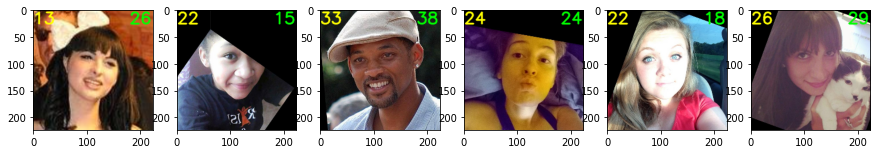

In [95]:
w, b = stochastic_gradient_descent(age_train, features_train, age_val, features_val)
loss = evaluate(w, b, age_val, features_val)
print("Your validate loss is:", round(loss, 3))

# Test and Generate results file

In [96]:
prediction = test(w, b, features_test, filename='softmax.txt')
print("Test results has saved to softmax.txt")
print(prediction[:10])

Test results has saved to softmax.txt
[24.5105031  61.34906333 48.30284408 20.82374095 31.12424624 35.77634544
 43.57679999 41.23357449 22.71179967 57.11651072]
